# Network Science
## Final Project

### What happens with robustness in the presence of interdependent networks?

#### Ben Murphy 16-714-925
#### Florian Rüegsegger 16-714-737
#### Silvan Wehrli 15-703-275

## Introduction

We analyse the streetnetwork of Newyork/Manhattan in order to find where weakpoints of the system lie. In order to confirm our findings we define metrics by which we measure the speed at which cars can traverse through the network. 

- Randomly select two nodes and check how long it takes from Node A to B
- check average path length
- define metrics speed (Use edge attributes) (speedlimit, distance, time), (amount of nodes), (traffic?/real traffic data)
- simulate traffic
- compare to real traffic data
- randomly attack network in order to verify our choice of nodes
- try with other networks? Zurich?
- 


In [3]:
import networkx as nx
from networkx import read_graphml
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
from typing import List, Dict
import seaborn as sns
import osmnx as ox
import random
from tqdm.notebook import tqdm
from collections import Counter
from scipy.special import factorial
import powerlaw
import time
#Wheter the data set should be downloaded from the internet, must be done once.
LOAD = False

### Plotting functions

In [9]:
def plot_hist(data: List[float], title: str,label: str, xlabel: str = "", density=True, show=True):
    plt.hist(data, label=label, density=density)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(f"{'density' if density else 'count'} ")
    if show:
        plt.legend()
        plt.show()
    

## General Data

In [6]:
def clean_data(graph, key_for_removal: str) -> nx.Graph:
    
    new_graph = nx.DiGraph()
    new_graph.graph = graph.graph
    for edge in graph.edges():
        start, end = edge
        keys = graph[start][end][key_for_removal].keys()
        data = {}
        for key in keys:
            if key in ["highway","name", "lanes","maxspeed","Bridge","Tunnel", "length", "speed_kph", "travel_time"]:
                data[key] = graph[start][end][key_for_removal][key]
                if key == "length":
                    data[key] = float(data[key])
        new_graph.add_edge(start,end,**data)

    for node in graph.nodes().keys():
        for key in graph.nodes()[node].keys():
            if key in ["x", "y"]: 
                new_graph.nodes()[node][key] = float(graph.nodes()[node][key])
            elif key == "highway":
                new_graph.nodes()[node][key] = graph.nodes()[node][key]

                
    return new_graph

In [2]:
if LOAD:
    print("Downloading data")
    graph = ox.graph_from_place('New York, USA', network_type='drive')
    print("adding the need for speed")
    graph = ox.speed.add_edge_speeds(graph)
    graph = ox.speed.add_edge_travel_times(graph, precision=1)
    print("Writing uncleaned to file")
    ox.save_graphml(graph, "data/unclean_and_tainted.graphml")
    print("Cleaning data")
    graph = clean_data(graph,0)
    print("write to file")
    nx.write_gml(graph,"data/osmnx_cleaned.gml")
graph = nx.read_gml("data/osmnx_cleaned.gml")

## Data Inspection

In [3]:
uncleaned_graph = ox.load_graphml("data/unclean_and_tainted.graphml")

In [60]:
topnode = {
    "node": None,
    "y": 0
}

for node in uncleaned_graph:
    n = uncleaned_graph.nodes()[node]

    if n['y'] > topnode['y']:
        topnode["node"] = node
        topnode["y"] = n["y"]
topnode = topnode["node"]
print(topnode)
node = np.random.choice(uncleaned_graph.nodes())
print(node)

42736818
5473204226


Let's first visualize the network. As one can see below, the network represents indeed the street network of New York!

In [48]:
ox.plot_graph(uncleaned_graph, figsize=(80,80))

TypeError: plot_graph() got an unexpected keyword argument 'with_labels'

Now let's also have a quick look at some rather basic stats.

In [15]:
print(f"n nodes: {len(graph.nodes())}")
print(f"n edges: {len(graph.edges())}")
print(f"graph is directed: {nx.is_directed(graph)}")
print(f"graph weakly connected: {nx.is_weakly_connected(graph)}") # Treat edges as undirected
print(f"graph strongly connected: {nx.is_strongly_connected(graph)}") # Treat edges as directed

n nodes: 55366
n edges: 140022
graph is directed: True
graph weakly connected: True
graph strongly connected: False


### Component Analysis

As the network represents a street network (see figure above), one would expect that there must be at least one very big component --> almost all streets are connected, i.e. one can travel from one point to any other point in the city. Possibly, there are components with a very low size that cannot be reached (e.g. private streets). But is this actually true? Let's have a look at the distribution of sizes of strongly connected components in the network.

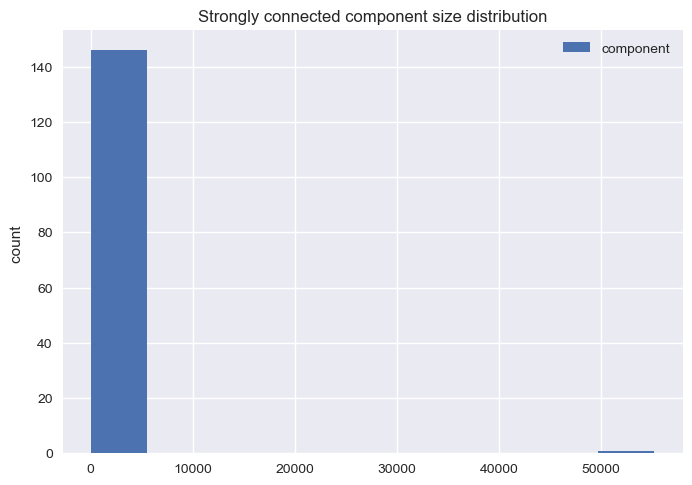

In [196]:
component_size = np.array([len(value) for index, value in enumerate(sorted(nx.strongly_connected_components(graph), key=len, reverse=True))])
plot_hist(component_size, "Strongly connected component size distribution", "component", density=False)

Yes, this is indeed the case: We have a lot of small unconnected components (strong connectivity).

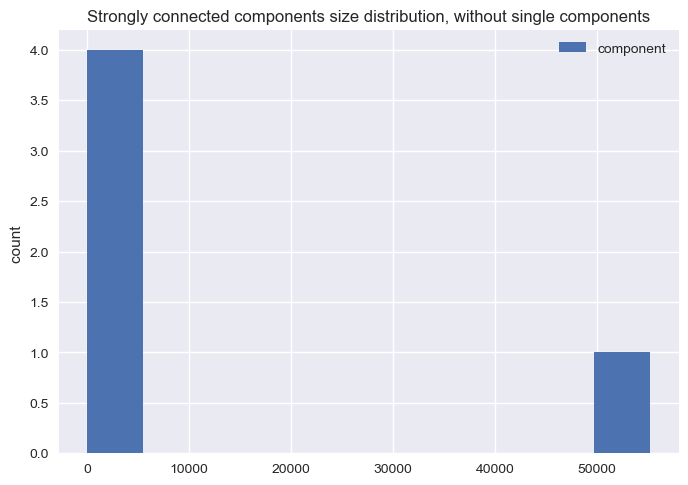

In [197]:
plot_hist(component_size[component_size>1], "Strongly connected components size distribution, without single components", "component", density=False)

By removing all components with size < 2 we end up with 9 components.  
For our further analysis, we focus on the biggest component and remove all the small ones as they hardly matter.

In [11]:
largest_component = list(sorted(nx.strongly_connected_components(graph), key=len, reverse=True))[0]
graph = graph.subgraph(largest_component).copy()

In [199]:
print(f"n nodes: {len(graph.nodes())}")
print(f"n edges: {len(graph.edges())}")
print(f"graph is directed: {nx.is_directed(graph)}")
print(f"graph weakly connected: {nx.is_weakly_connected(graph)}") # Treat edges as undirected
print(f"graph strongly connected: {nx.is_strongly_connected(graph)}") # Treat edges as directed

n nodes: 55216
n edges: 139814
graph is directed: True
graph weakly connected: True
graph strongly connected: True


### Degree Distribution

As a next step, we'll have a look at the degree distribution and which theoretical distribution this real network is similar to (relevant for the percolation / robustness analysis as this allow to make comparisons to a randomly generated network).

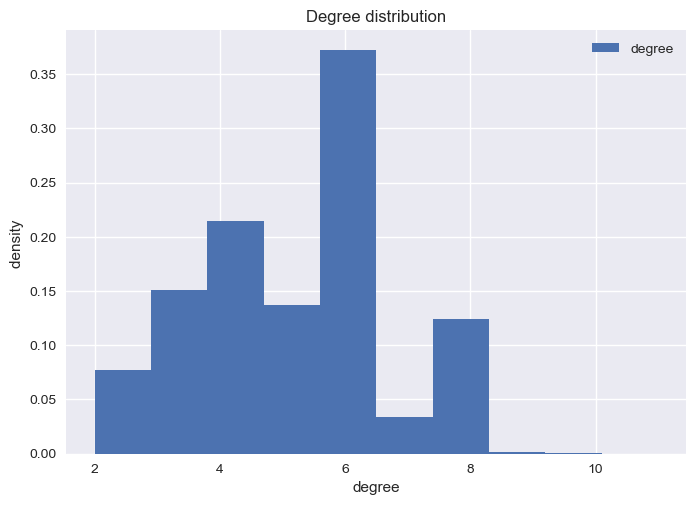

In [200]:
degrees = [i[1] for i in graph.degree()]
plot_hist(degrees, "Degree distribution", "degree", "degree")

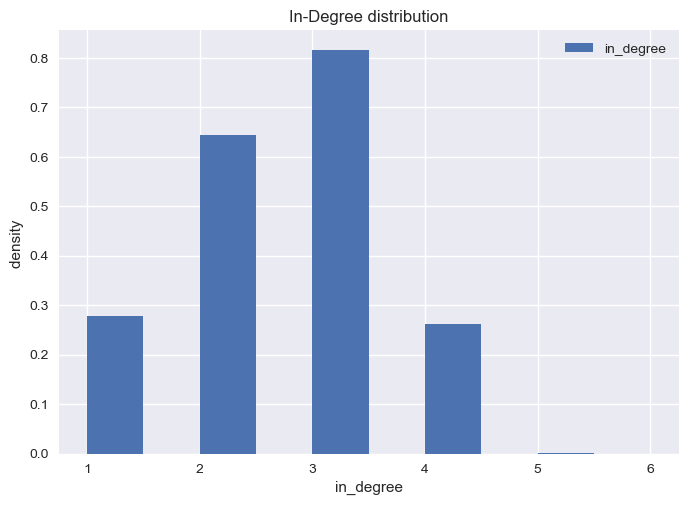

In [201]:
in_degrees = [i[1] for i in graph.in_degree()]
plot_hist(in_degrees, "In-Degree distribution", "in_degree", "in_degree")

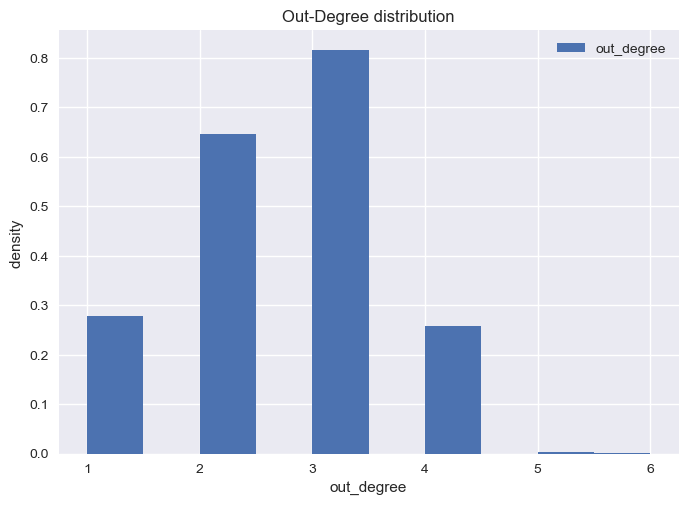

In [202]:
out_degrees = [i[1] for i in graph.out_degree()]
plot_hist(out_degrees, "Out-Degree distribution", "out_degree", "out_degree")

/opt/anaconda3/envs/networkscience/lib/python3.7/site-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


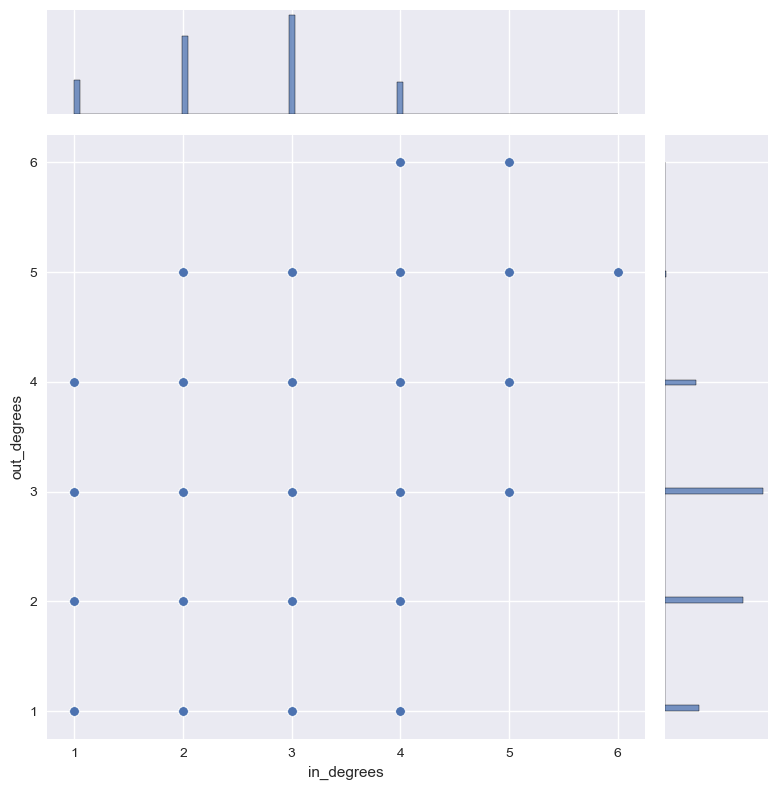

In [203]:
degrees = {
    "in_degrees":in_degrees,
    "out_degrees":out_degrees
}
sns.jointplot(x="in_degrees",y="out_degrees",data=degrees, size=8)


In [4]:
degrees = [i[1] for i in graph.degree()]
deg_mean = np.mean(degrees)
spacing = np.linspace(np.min(degrees), np.max(degrees), np.max(degrees)-np.min(degrees))
poisson = ((deg_mean**spacing) / factorial(spacing) ) * np.exp(-deg_mean)
#poisson = np.random.poisson(spacing)
degrees = np.array(degrees)
exponential = deg_mean**-1 * np.exp(-spacing / deg_mean) 
#fit = powerlaw.Fit(degrees, verbose=False)

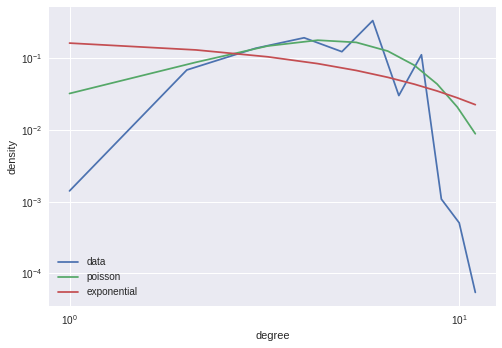

In [7]:
counts = Counter(degrees)

keys = sorted(counts.keys())
values = [counts[key] / len(degrees) for key in keys]
plt.plot(keys,values, label="data")
plt.plot(spacing,poisson, label="poisson")
plt.plot(spacing,exponential, label="exponential")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("degree")
plt.ylabel("density")
plt.legend()
plt.show()

One can see that the distribution more or less follows the poisson distributon. An exception are nodes with a rather high degree. This makes sense: it is rather unlikely that there are crossings in a city with streets in many directions.

### Assortativity

In [18]:
if LOAD:
    avg_deg_graph = sum([value for _, value in graph.degree()])/graph.number_of_nodes()
    p = avg_deg_graph/graph.number_of_nodes()
    print("building erdos")
    er_graph = nx.generators.random_graphs.erdos_renyi_graph(n=graph.number_of_nodes(), p=p, directed=True)
    nx.write_gml(er_graph, "data/erdos-renyi.gml")

building erdos


In [23]:
er_graph = nx.read_gml("data/erdos-renyi.gml")

In [21]:
rand_graph = nx.directed_configuration_model(dict(graph.in_degree()).values(), dict(graph.out_degree()).values(), seed=128)
print(f"graph degree assortativity: {nx.degree_assortativity_coefficient(graph)}")
print(f"Random graph degree assortativity: {nx.degree_assortativity_coefficient(rand_graph)}")
print(f"erdos degree assortativity: {nx.degree_assortativity_coefficient(er_graph)}")


graph degree assortativity: 0.43545421403541784
Random graph degree assortativity: -0.001148981253546615
erdos degree assortativity: 0.0006428679754223927


In [24]:
print(f"graph density: {nx.density(graph)}")
print(f"rand graph density: {nx.density(rand_graph)}")
print(f"erdos density: {nx.density(er_graph)}")


graph density: 4.5859428933963864e-05
rand graph density: 4.5859428933963864e-05
erdos density: 9.168736956791729e-05


In [ ]:
shortest = nx.shortest_path(graph,"43010059","42485784")
shortest_lenght = nx.shortest_path(graph,"43010059","42485784", weight="travel_time")


In [ ]:
graph["42467330"]["42510401"]

In [ ]:
# calculate weights
# include speed_limit, distance, (amount of lanes, (time of day/traffic)),
# calculate weight by looking at neighbouring nodes
# Time = distance / speed_limit
# Weight = (Time - min(Time)) / (max(time) - min(time)) # standardise to get values between (0,1)
# lower weight => less time => better route



In [ ]:
graph["43010059"]["42997670"]

### 

### Percolation / Robustness
#### How does the size of largest component change when nodes/links are removed?
3 Strategies:
- strategy 1: remove nodes randomly
<br>idea: baseline
- strategy 2: 
<br>(a) remove nodes with the highest betweenness centrality (unweigthed)
<br> (b) remove nodes with the highest betweenness centrality (weighted: travel time)
<br>idea: target nodes that are important routes for all routes through the city
- strategy 3: remove links with low travel times
<br>idea: target links (streets) that allow to travel especially fast through the city

For each of the unweigthed strategies we will use a random network to compare results, i.e. to see whether the real network berforms better or worse than an artificially built network. As we have seen before, the degree distribution of the network more or less follows a Poisson distribution, therefore, we will use a Erdős–Rényi graph as our random comparison network.

In [4]:
STEP_SIZE = 20

In [67]:
def robustness(graph, removal_mode='random', link_attribute=None, step_size=STEP_SIZE, show_progress=True):
    if removal_mode == 'random':
        removal_order = random.sample(graph.nodes(), graph.number_of_nodes())
        
    elif removal_mode == 'betweenness_centrality':
        k = int(graph.number_of_nodes()*0.05) # only consider 5% of the nodes as sample for calculation
        bc = nx.algorithms.centrality.betweenness_centrality(graph, k=k, weight=link_attribute)
        removal_order = [i[0] for i in sorted(bc.items(), key=lambda x: x[1], reverse=True)]
        
    elif removal_mode == 'edge':
        if link_attribute:
            removal_order = sorted(list(graph.edges()), key=lambda x: graph[x[0]][x[1]][link_attribute])
        else:
            removal_order = random.sample(graph.edges(), graph.number_of_edges())
            
    else:
        raise Exception(f"removal mode: {removal_mode} not supported")
        
    graph_copy = graph.copy()
    size_largest_comp = [len(sorted(nx.strongly_connected_components(graph_copy), key=len, reverse=True)[0])]
    
    if show_progress:
        if removal_mode == 'weighted_link':
            pbar = tqdm(total=graph.number_of_edges()//STEP_SIZE)
        else:    
            pbar = tqdm(total=graph.number_of_nodes()//STEP_SIZE)


    make_img=True
    image_multiplier = 100
    for i, e in enumerate(removal_order):
        if removal_mode == 'weighted_link':
            graph_copy.remove_edge(e[0], e[1])
        else:
            if not (e == "42736818" or e == "5473204226"): 
                graph_copy.remove_node(e)

        if i % STEP_SIZE == 0:
            largest_component = list(sorted(nx.strongly_connected_components(graph_copy), key=len, reverse=True))[0]
            size_largest_comp.append(len(largest_component))
            if(i % (STEP_SIZE*image_multiplier) == 0)and make_img:
                try:
                    create_image(graph_copy.subgraph(graph_copy).copy(), removal_mode, i//(STEP_SIZE*image_multiplier))
                except nx.NetworkXNoPath: 
                    make_img = False
                    print(f"no path available anymore at i={i}")

            
            if show_progress:
                pbar.update(1)
    
    return size_largest_comp

In [68]:
import os


def setup_osmnx():

    uncleaned_graph = ox.load_graphml("data/unclean_and_tainted.graphml")
    largest_component = list(sorted(nx.strongly_connected_components(uncleaned_graph), key=len, reverse=True))[0]
    uncleaned_graph = uncleaned_graph.subgraph(largest_component).copy()
    return uncleaned_graph

def create_image(graph, name: str,num: int):
    start = time.perf_counter()
    try:
        os.mkdir("imgs")
    except FileExistsError:
        pass
    #ox_graph = nx.read_graphml("data/unclean_and_tainted.graphml")


    nodes_to_remove = []
    edges_to_remove = []
    for node in uncleaned_graph:
        
        if not graph.has_node(str(node)):
            nodes_to_remove.append(node)
            
    for edge in uncleaned_graph.edges():
        if not graph.has_edge(str(edge[0]),str(edge[1])):
            edges_to_remove.append(edge)

    uncleaned_graph.remove_nodes_from(nodes_to_remove)
    uncleaned_graph.remove_edges_from(edges_to_remove)

    bot_left = 42947240
    top_right = 42732060

    node1 = 42736818
    node2 = 5473204226

    start2 = time.perf_counter()
    #print(f"until shortest path: {start2-start}")
    path = nx.shortest_path(uncleaned_graph,node1, node2, weight="travel_time")
    start3 = time.perf_counter()
    #print(f"with shortest path: {start3-start2}")
    fig, ax = ox.plot_graph_route(uncleaned_graph,path, route_color="r", node_edgecolor='k', node_size=1, 
                            node_zorder=3, edge_color="w", edge_linewidth=1, figsize=(20,20), route_linewidth=5,
                            route_alpha=1, node_color="b", show=False, save=True, filepath=f"imgs/{name}_{num}.png")
    start4 = time.perf_counter()
    #print(f"img creation: {start4-start3}")
    #print(f"total: {start4-start}")
    #fig.savefig(f"imgs/{name}_{num}.png", format="png")

In [226]:
degrees = np.array([value for _, value in graph.degree()])
mean_degree = np.mean(degrees)
exp_mean_degree = np.mean(degrees**2)
print(f"<k^2>: {exp_mean_degree}")
print(f"<k>(<k>+1): {mean_degree * (mean_degree+1)}")
print(f"<k^2> > <k>(<k>+1): {exp_mean_degree > mean_degree * (mean_degree+1)}")

<k^2>: 28.499166908142566
<k>(<k>+1): 30.710953037226638
<k^2> > <k>(<k>+1): False


#### strategy 1: random node removal

#### real network

In [69]:
uncleaned_graph = setup_osmnx()
size_largest_comp_random = robustness(graph)

/tmp/ipykernel_9892/2955075685.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  removal_order = random.sample(graph.nodes(), graph.number_of_nodes())


  0%|          | 0/2760 [00:00<?, ?it/s]

no path available anymore at i=4000


#### Erdős–Rényi graph

In [78]:
avg_deg_graph = sum([value for _, value in graph.degree()])/graph.number_of_nodes()
p = avg_deg_graph/graph.number_of_nodes()
er_graph = nx.generators.random_graphs.erdos_renyi_graph(n=graph.number_of_nodes(), p=p, directed=True)

In [79]:
er_size_largest_comp_random = robustness(er_graph)

  0%|          | 0/2760 [00:00<?, ?it/s]

In [95]:
steps = np.arange(0, 1, 1/len(size_largest_comp_random))

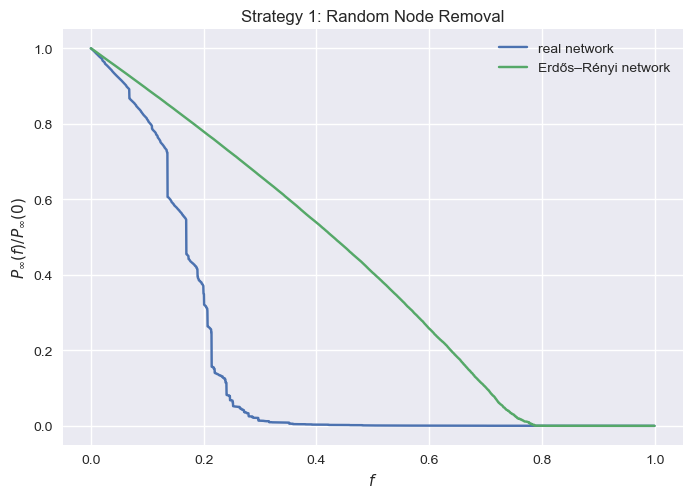

In [110]:
fig = plt.figure(dpi=100)
plt.title('Strategy 1: Random Node Removal')
plt.plot(steps, [s/size_largest_comp_random[0] for s in size_largest_comp_random], label='real network')
plt.plot(steps, [s/er_size_largest_comp_random[0] for s in er_size_largest_comp_random], label='Erdős–Rényi network')
plt.xlabel(r'$f$')
plt.ylabel(r'$P_\infty(f)/P_\infty(0)$')
plt.legend()
plt.show()

This plot offers a first interesting insight: The breaking apart of the component happens much faster for the real network than the random network. This indicates that the network does <b>not</b> display enhanced robustness. Should this be true, the equation ⟨𝑘2⟩ > ⟨𝑘⟩(⟨𝑘⟩ + 1) should <b>not</b> hold.
<br>And indeed, this is the case:

#### strategy 2: remove nodes with the highest betweenness centrality

#### (a) unweighted

#### real network

In [180]:
start = time.time()
size_largest_comp_bc = robustness(graph, removal_mode='betweenness_centrality', link_attribute=None)
end = time.time()
print((end - start)/60) # in minutes

  0%|          | 0/2760 [00:00<?, ?it/s]

45.06473998626073


#### Erdős–Rényi graph

In [181]:
er_size_largest_comp_bc = robustness(er_graph, removal_mode='betweenness_centrality', link_attribute=None)

  0%|          | 0/2760 [00:00<?, ?it/s]

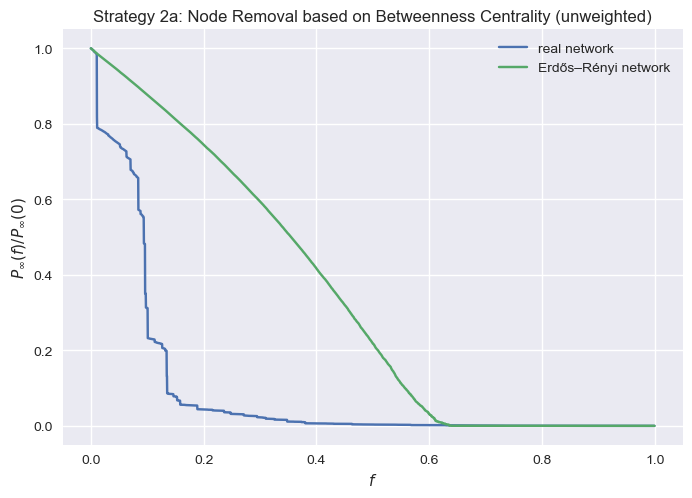

In [182]:
fig = plt.figure(dpi=100)
plt.style.use('seaborn')
plt.title('Strategy 2a: Node Removal Based on Betweenness Centrality (unweighted)')
plt.plot(steps, [s/size_largest_comp_bc[0] for s in size_largest_comp_bc], label='real network')
plt.plot(steps, [s/er_size_largest_comp_bc[0] for s in er_size_largest_comp_bc], label='Erdős–Rényi network')
plt.xlabel(r'$f$')
plt.ylabel(r'$P_\infty(f)/P_\infty(0)$')
plt.legend()
plt.show()

#### (b) weighted with travel time

#### real network

In [183]:
size_largest_comp_bcw = robustness(graph, removal_mode='betweenness_centrality', link_attribute='travel_time')

  0%|          | 0/2760 [00:00<?, ?it/s]

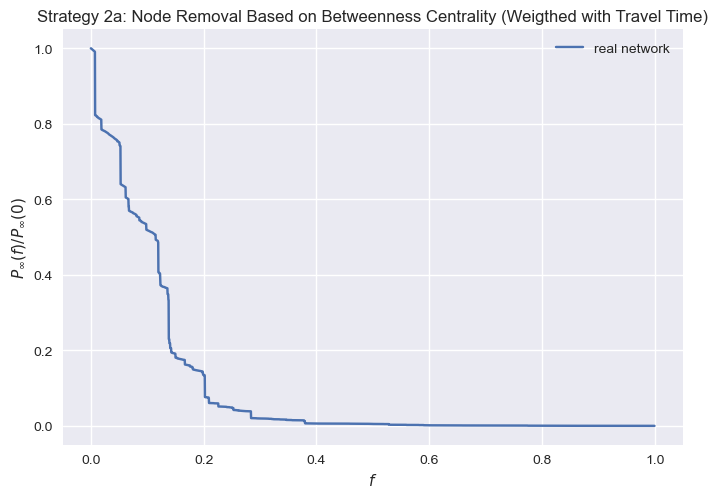

In [185]:
fig = plt.figure(dpi=100)
plt.style.use('seaborn')
plt.title('Strategy 2a: Node Removal Based on Betweenness Centrality (Weigthed with Travel Time)')
plt.plot(steps, [s/size_largest_comp_bcw[0] for s in size_largest_comp_bcw], label='real network')
plt.xlabel(r'$f$')
plt.ylabel(r'$P_\infty(f)/P_\infty(0)$')
plt.legend()
plt.show()

#### strategy 3: remove links with low travel times

#### real network

In [143]:
size_largest_comp_tt = robustness(graph, removal_mode='edge', link_attribute='travel_time')

  0%|          | 0/6990 [00:00<?, ?it/s]

In [144]:
steps_links = np.arange(0, 1, 1/len(size_largest_comp_tt))

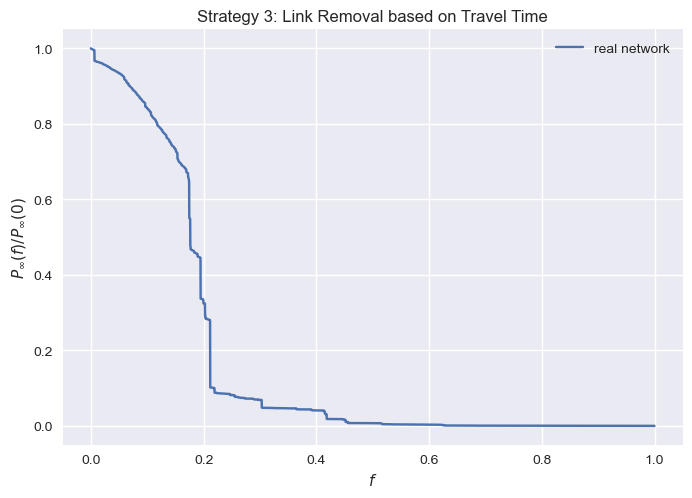

In [146]:
fig = plt.figure(dpi=100)
plt.style.use('seaborn')
plt.title('Strategy 3: Edge Removal Based on Travel Time')
plt.plot(steps_links, [s/size_largest_comp_tt[0] for s in size_largest_comp_tt], label='real network')
plt.xlabel(r'$f$')
plt.ylabel(r'$P_\infty(f)/P_\infty(0)$')
plt.legend()
plt.show()

#### strategy comparison for the real network

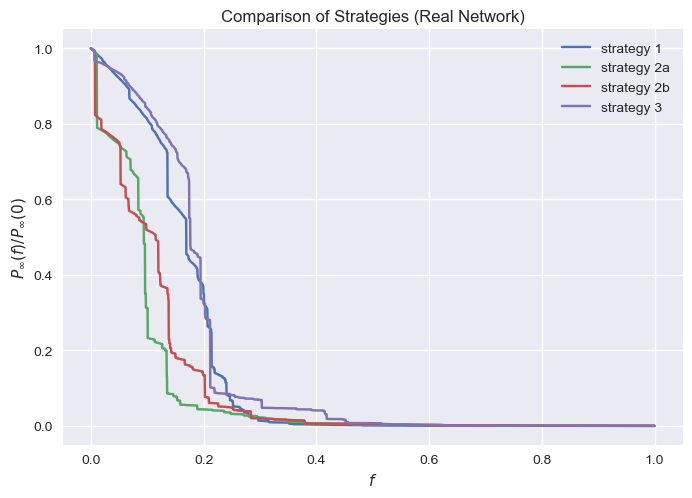

In [186]:
fig = plt.figure(dpi=100)
plt.style.use('seaborn')
plt.title('Comparison of Strategies (Real Network)')
plt.plot(steps, [s/size_largest_comp_random[0] for s in size_largest_comp_random], label='strategy 1')
plt.plot(steps, [s/size_largest_comp_bc[0] for s in size_largest_comp_bc], label='strategy 2a')
plt.plot(steps, [s/size_largest_comp_bcw[0] for s in size_largest_comp_bcw], label='strategy 2b')
plt.plot(steps_links, [s/size_largest_comp_tt[0] for s in size_largest_comp_tt], label='strategy 3')
plt.xlabel(r'$f$')
plt.ylabel(r'$P_\infty(f)/P_\infty(0)$')
plt.legend()
plt.show()

The best performing strategy is the one that removes nodes based on their betweenness centrality.

### Showcase

In [23]:
uncleaned_graph = ox.load_graphml("data/unclean_and_tainted.graphml")
largest_component = list(sorted(nx.strongly_connected_components(uncleaned_graph), key=len, reverse=True))[0]
uncleaned_graph = uncleaned_graph.subgraph(largest_component).copy()


False
False
55216


In [42]:
uncleaned_graph = setup_osmnx()
create_image(graph,"test",0)


55216


# Cascade Failure (CF)

## Betweeness
### Setup
In this scenario we assumed the following:
* Each node has a maximum capacity.
* each driver always takes the shortest path (based on travel time) and knows which nodes are active or not.
* If a node is attacked (e.g. traffic or accident) its streets are not available anymore.
* each node has a maximum load based on initial betweenness multiplied by a multiplier. If the maximum load is exceeded it crashes.

At the beginning n nodes are removed. The betweenness of the network is then recalculated and all nodes which exceed their maximum load are also removed. The CF stops if there is an iteration where no node was removed.  
For the initial attack we used two modes, random and target. random attacks n nodes randomly, while target attacks the n nodes with the highest betweenness.  

## Findings
Our model behaves differently from "classic" CFs. In a "classic" CFs a node fails if its neighbors fail, while in our model this is not necessarily true. If in our model a node is removed it can have an impact on far away nodes (e.g. a bridge is removed and all traffic is redirected to another bridge which is subsequently overloaded).
### Limitiations
Since calculating the betweenness centrality is an expensive task we simplified as follows:
* We reduced our graph to only Manhattan.
* We update our graph in badges. Normally one would attack a node, look which nodes subsequently fail and update the graph for each of them. In our case this was not possible since the computation is too expensive. We therefore attacked a node, removed all nodes that subsequently failed and then updated the graph. Sadly this limitation makes the Branching model impossible to compute.

In [7]:
if LOAD:
    print("Downloading data")
    test_graph = ox.graph_from_place('Manhattan, New York City, New York, USA', network_type="drive")
    print("adding the need for speed")
    test_graph = ox.speed.add_edge_speeds(test_graph)
    test_graph = ox.speed.add_edge_travel_times(test_graph, precision=1)
    print("Writing uncleaned to file")
    ox.save_graphml(test_graph, "data/uncleaned_manhattan.graphml")
    print("Cleaning data")

    test_graph = clean_data(test_graph,0)
    print("write to file")
    nx.write_gml(test_graph,"data/cleaned_manhattan.gml")

write to file


In [4]:
from abc import ABC, abstractmethod
class AbstractStrategy:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
    
    @abstractmethod
    def get_metric(self, graph: nx.Graph):
        pass

    @abstractmethod
    def __str__(self):
        pass

class BetweennessStrategy(AbstractStrategy):
    def __init__(self, k, normalized, weight):
        super(BetweennessStrategy, self).__init__(k=k, normalized=normalized, weight=weight)

    def get_metric(self, graph: nx.Graph):
        return nx.betweenness_centrality(graph, **self.kwargs)
    
    def __str__(self):
        return f"Betweenness_k={self.kwargs['k']}_norm={int(self.kwargs['normalized'])}_weight={self.kwargs['weight']}"
    
class PercolationStrategy(AbstractStrategy):
    def __init__(self):
        super(PercolationStrategy,self).super()
    


    def get_metric(self, graph: nx.Graph):
        return nx.percolation_centrality(graph)

class BetweennessStrategyFast(AbstractStrategy):
    """
    Takes a sample of nodes for the betweenness metric.
    In order to stay statistically relevant the betweenness metric is executed
    iterations times and then averaged.
    """
    def __init__(self, k, normalized, weight, iterations):
        self.iterations = iterations
        super(BetweennessStrategyFast, self).__init__(k=k, normalized=normalized, weight=weight)

    def get_metric(self, graph: nx.Graph):
        betweennesses = []
        for i in range(self.iterations):
            betweennesses.append(nx.betweenness_centrality(graph, **self.kwargs))
        
        result = {}
        for node in betweennesses[0].keys():
            temp = 0
            for b in betweennesses:
                temp+=b[node]
            result[node] = temp/len(betweennesses)

        return result
    
    def __str__(self):
        return f"Betweenness_k={self.kwargs['k']}_norm={int(self.kwargs['normalized'])}_weight={self.kwargs['weight']}"
    

In [7]:
class CascadeFailure:
    def __init__(self, path: str, ox_path: str, strategy: AbstractStrategy, multiplier: float=1.5):
        self.path = path
        self.ox_path = ox_path
        self.strategy = strategy
        self.muliplier = multiplier
        self.prepare_graph()

    def __str__(self):
        return f"CF_max_multiplier={self.muliplier}_{self.strategy}"

    def prepare_graph(self):
        self.graph = nx.read_gml(self.path) 
        self.graph = self.get_largest_component(self.graph)
        #betweenness = nx.betweenness_centrality(self.graph, k=k)
        #self.graph = self.strategy.prepare_graph(self.graph)
        metric = self.strategy.get_metric(self.graph)
        for key in metric.keys():
            n = self.graph.nodes()[key]
            #n["is_active"] = True
            n["metric"] = metric[key]
            n["max_metric"] = metric[key] * self.muliplier


    def get_largest_component(self,graph)->nx.Graph:
        largest_component = list(sorted(nx.strongly_connected_components(graph), key=len, reverse=True))[0]
        return graph.subgraph(largest_component).copy()


    def create_image(self,save=False, filepath=None, show=False):
        # load ox graph
        ox_graph = ox.load_graphml(self.ox_path)
        ox_graph = self.get_largest_component(ox_graph)

        nodes_to_color = []
        count = 0
        for node in ox_graph:
            if not self.graph.has_node(str(node)):
                nodes_to_color.append(node)
                ox_graph.nodes()[node]["color"] = 0
                
            else:
                ox_graph.nodes()[node]["color"] = 1
                count+=1

        edges_to_color = []
        for edge in ox_graph.edges():
            if not self.graph.has_edge(edge[0], edge[1]):
                ox_graph[edge[0]][edge[1]][0]["color"] = 0
            else:
                ox_graph[edge[0]][edge[1]][0]["color"] = 1
        node_color = ox.plot.get_node_colors_by_attr(ox_graph,"color", cmap="Paired")
        #edge_color = ox.plot.get_edge_colors_by_attr(ox_graph,"color", cmap="Paired") 
        #print(f"Debug: graph has {self.graph.number_of_nodes()} nodes, ox has {count} colored nodes")
        ox.plot_graph(ox_graph, node_color=node_color, edge_color="w", figsize=(20,20), bgcolor="k", save=save, filepath=filepath, show=show)

    def attack_nodes(self, n=20, removal_mode="random", image_each_iteration=False, attack_number=1,filepath="imgs/cascade"):

        if removal_mode=="random":
            for i in range(n):
                node = np.random.choice(self.graph)
                self.graph.remove_node(node)

        if removal_mode == "target":
            for i in range(n):
                node_to_remove = None
                max = -1
                for node in self.graph:
                    curr_node = self.graph.nodes()[node]
                    if curr_node["metric"]>max:
                        node_to_remove = node
                        max = curr_node["metric"]
                self.graph.remove_node(node_to_remove)

        print(f"Removed {n} nodes with mode {removal_mode}.")
        if image_each_iteration:
            self.create_image(True,f"{filepath}/{self}_attack#{attack_number}_initial.png")


        print("Start Cascading")
        iteration = 0
        while True:
            metric = self.strategy.get_metric(self.graph)
            #betweenness = nx.betweenness_centrality(self.graph,self.k)
            nodes_to_remove = []
            for key in metric.keys():
                node = self.graph.nodes()[key]
                if node["max_metric"] <= metric[key]:
                    nodes_to_remove.append(key)

            if len(nodes_to_remove) == 0:
                break

            self.graph.remove_nodes_from(nodes_to_remove)

            if image_each_iteration:
                self.create_image(save=True, filepath=f"{filepath}/{self}_attack#{attack_number}_{removal_mode}_n#{n}_iter#{iteration}.png", show=False)
            print(f"Cascading iteration {iteration} overloaded {len(nodes_to_remove)}")
            print(f"Remaining nodes: {self.graph.number_of_nodes()}")

            iteration+=1
            









Removed 1 nodes with mode target.
Start Cascading
Cascading iteration 0 overloaded 346
Remaining nodes: 4179
Cascading iteration 1 overloaded 761
Remaining nodes: 3418
Cascading iteration 2 overloaded 538
Remaining nodes: 2880
Cascading iteration 3 overloaded 66
Remaining nodes: 2814
Cascading iteration 4 overloaded 24
Remaining nodes: 2790
Cascading iteration 5 overloaded 3
Remaining nodes: 2787


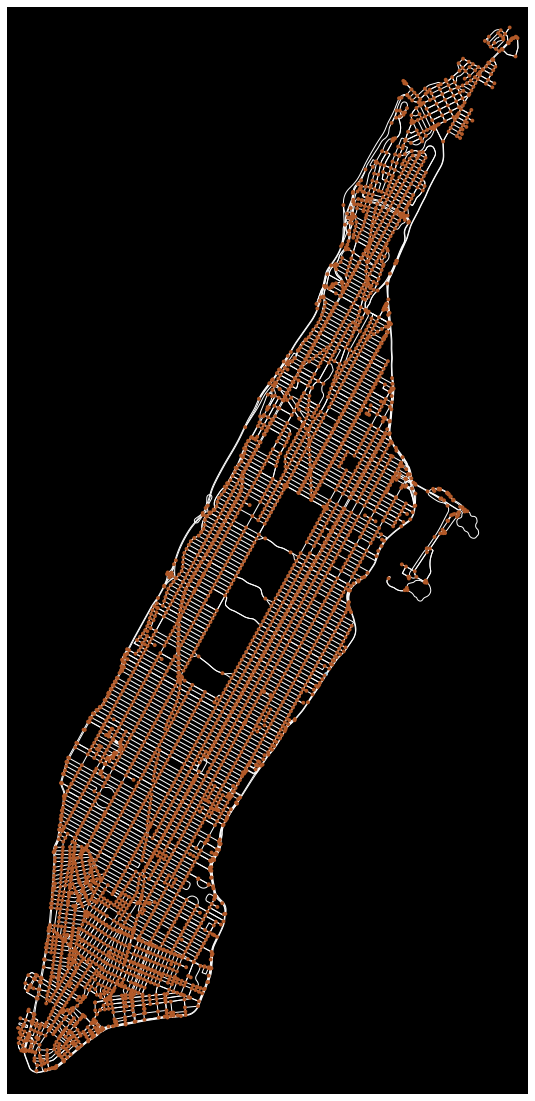

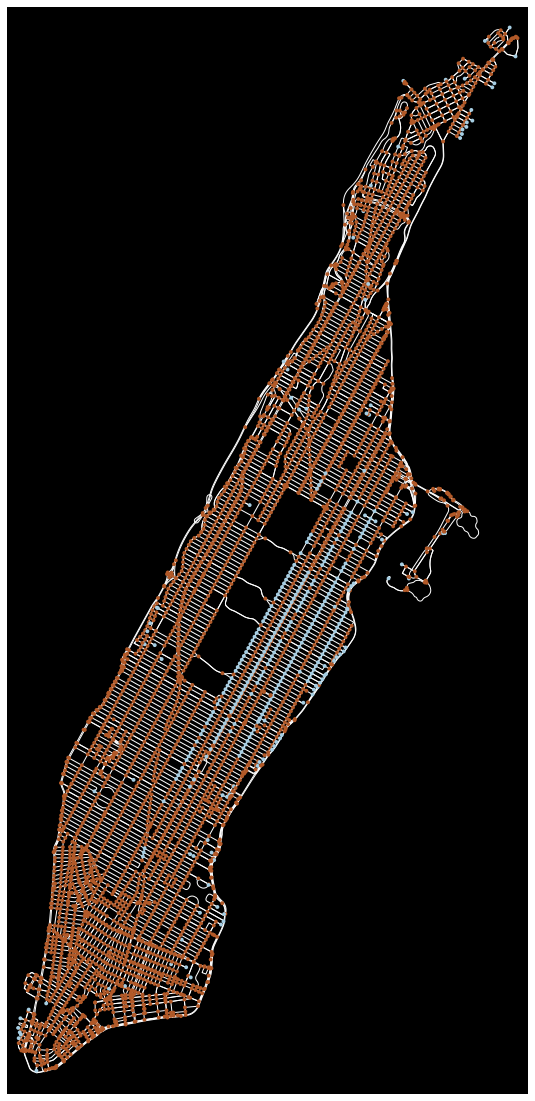

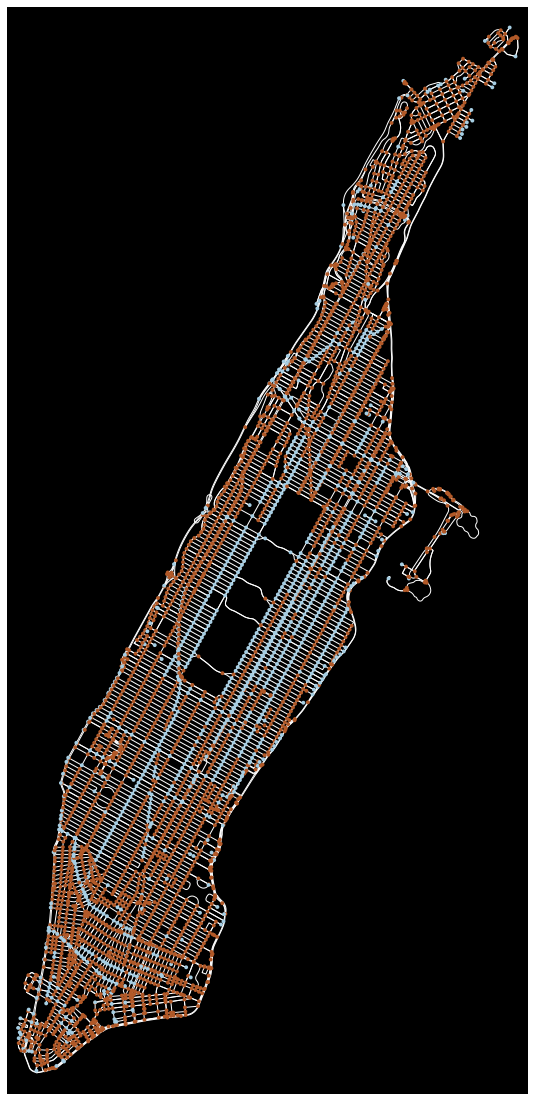

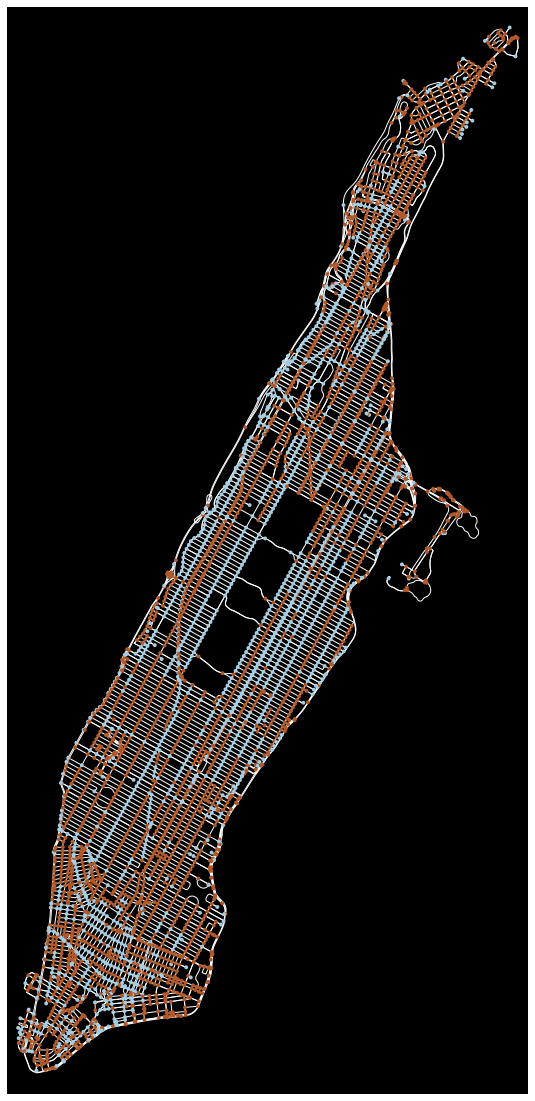

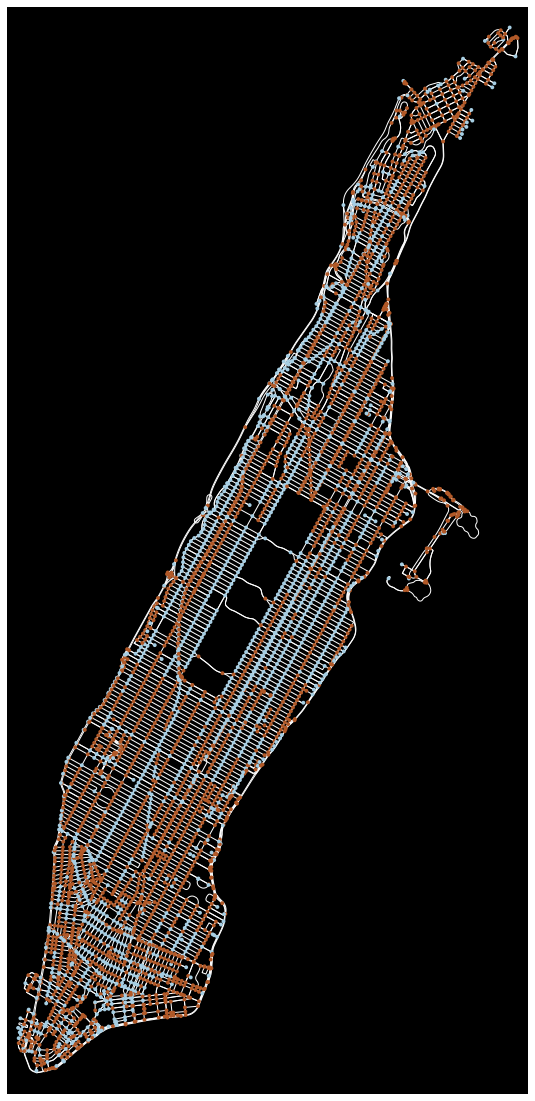

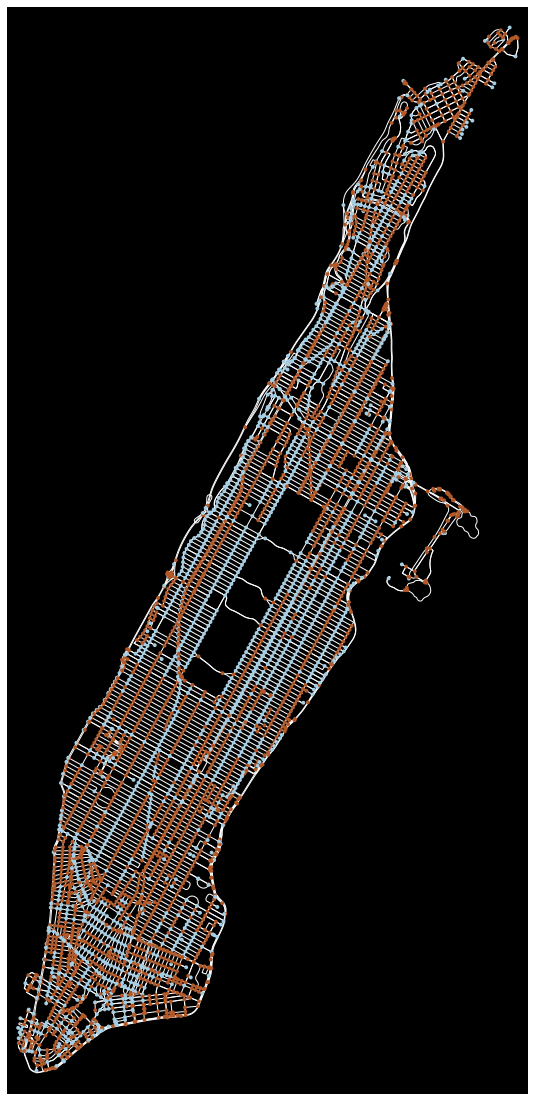

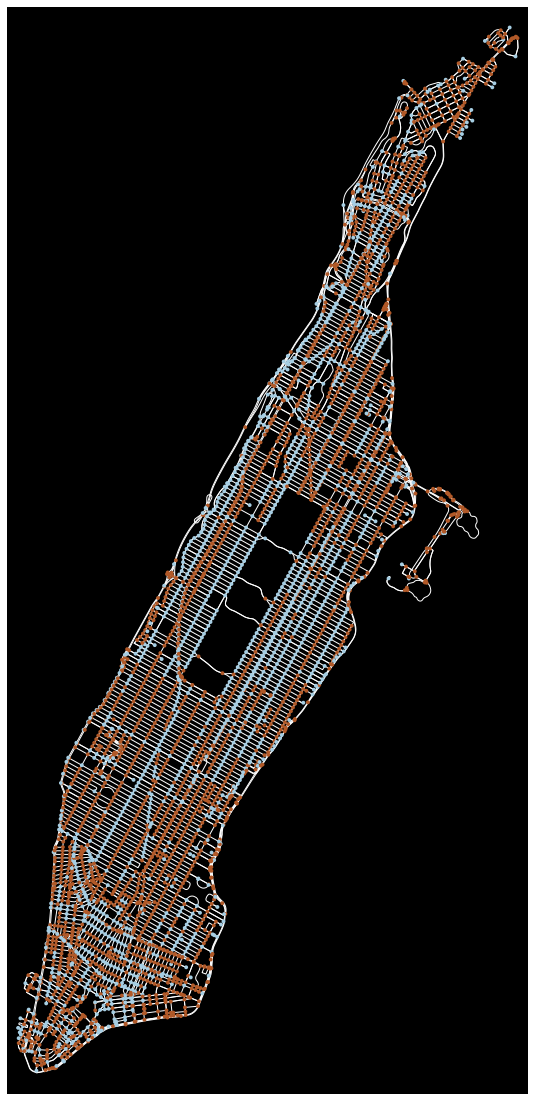

In [9]:
bs = BetweennessStrategy(k=None, normalized=True, weight="travel_time")
cf = CascadeFailure("data/cleaned_manhattan.gml", "data/uncleaned_manhattan.graphml",strategy=bs,multiplier=1.5)
cf.attack_nodes(1, removal_mode="target", image_each_iteration=True)